In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, MaxPooling1D, Flatten
from keras.models import Sequential
import os
from keras.layers import Dense, Activation, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
import joblib
# import rc
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# how to use .h5 file
# https://www.tensorflow.org/tutorials/keras/save_and_load


import warnings
warnings.filterwarnings('ignore')

c:\Users\hyha1\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [27]:
# 모든 데이터를 합친 데이터(정리된 데이터)
data = pd.read_csv('data/merge_all/merge_drop.csv')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   거래년월일           5782 non-null   object 
 1   자동차용 경유 가격 (원)  5782 non-null   float64
 2   전월비(%)          5782 non-null   float64
 3   평균              5782 non-null   float64
 4   거래량             5782 non-null   float64
dtypes: float64(4), object(1)
memory usage: 226.0+ KB


In [30]:
# 자동차용 경유 가격 (원) 컬럼 이름 변경
data = data.rename(columns={'자동차용 경유 가격 (원)':'경유가격'})
data = data.drop(['거래량'], axis=1)
data

,거래년월일,경유가격,전월비(%),평균
0,2000-01-03,583.35,4.0,5600.0
1,2000-01-04,583.35,4.0,5600.0
2,2000-01-05,583.35,4.0,5620.0
3,2000-01-06,583.35,4.0,5700.0
4,2000-01-07,583.35,4.0,5670.0
...,...,...,...,...
5777,2022-11-24,1879.15,-8.0,6100.0
5778,2022-11-25,1879.15,-8.0,6100.0
5779,2022-11-28,1879.15,-8.0,5664.0
5780,2022-11-29,1879.15,-8.0,5592.0


In [37]:
# 경유가격 컬럼을 rolling 30일로 이동평균 shift 30일
#data['경유가격_30'] = data['경유가격'].rolling(30).mean().shift(30)
data['경유가격_30'] = data['경유가격'].rolling(1).mean().shift(30)
data['전월비_30'] = data['전월비(%)'].rolling(1).mean().shift(30)

data

,거래년월일,경유가격,전월비(%),평균,경유가격_30,전월비_30
0,2000-01-03,583.35,4.0,5600.0,NaN,NaN
1,2000-01-04,583.35,4.0,5600.0,NaN,NaN
2,2000-01-05,583.35,4.0,5620.0,NaN,NaN
3,2000-01-06,583.35,4.0,5700.0,NaN,NaN
4,2000-01-07,583.35,4.0,5670.0,NaN,NaN
...,...,...,...,...,...,...
5777,2022-11-24,1879.15,-8.0,6100.0,1838.34,-6.1
5778,2022-11-25,1879.15,-8.0,6100.0,1838.34,-6.1
5779,2022-11-28,1879.15,-8.0,5664.0,1838.34,-6.1
5780,2022-11-29,1879.15,-8.0,5592.0,1838.34,-6.1


In [41]:
data = data.drop(['경유가격', '전월비(%)'], axis=1)
data

KeyError: "['거래량'] not found in axis"

In [102]:
# # "자동차용 경유 가격 (원)"의 이동평균을 # 코드를 함수로 만든다. 당일 제외
# def make_ma(df, col, ma_list):
#     for ma in ma_list:
#         df[col + '_' + str(ma) + 'MA'] = df[col].rolling(window=ma).mean().shift(1)
#     return df

# # "자동차용 경유 가격 (원)"의 이동평균을 구한다
# # data = make_ma(data, '경유가격', [5, 20, 60, 300])
# data = make_ma(data, '경유가격', [3, 5, 7, 20, 30])

# # # 거래량, 전월비 컬럼 제거
# data = data.drop(['거래량'], axis=1)
# data = data.drop(['전월비(%)'], axis=1)


# # "자동차용 경유 가격 (원)" 컬럼의 결측치를 제거한다
# data = data.dropna()

# #reset_index  하기 
# data = data.reset_index(drop=True)

In [44]:
# data 거래년월일 컬럼을 2022-10-30 까지만 사용
train = data[data['거래년월일'] <= '2022-01-01']
#y_train = data[data['거래년월일'] <= '2022-10-31']

# data 거래년월일 컬럼을 2022-10-30 일부터 사용
test = data[data['거래년월일'] > '2022-01-01']
#y_test = data[data['거래년월일'] > '2022-10-31']


In [45]:
# 데이터 나누기
# train_X = train[['경유가격_5MA', '경유가격_20MA', '경유가격_60MA', '경유가격_300MA']]
# train_Y = train['경유가격']
# test_X = test[['경유가격_5MA', '경유가격_20MA', '경유가격_60MA', '경유가격_300MA']]
# test_Y = test['경유가격']

# train_X = train[['경유가격_3MA', '경유가격_5MA', '경유가격_7MA', '경유가격_20MA', '경유가격_30MA']]
# train_Y = train['경유가격']
# test_X = test[['경유가격_3MA', '경유가격_5MA', '경유가격_7MA', '경유가격_20MA', '경유가격_30MA']]
# test_Y = test['경유가격']


#-----------------------------
train_X = train[['경유가격_30', '전월비_30']]
train_Y = train['평균']
test_X = test[['경유가격_30', '전월비_30']]
test_Y = test['평균']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)    

In [47]:
# 데이터 정규화 하기
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1)) # 2차원으로 만들어주기
y_test = scaler_y.transform(y_test.values.reshape(-1,1))

In [48]:
# xgb_model = XGBRegressor()

# xgb_param_grid={
#     'n_estimators' : [100,200,300,400,500],
#     'learning_rate' : [0.01,0.05,0.1,0.15],
#     'max_depth' : [3,5,7,10,15],
#     'gamma' : [0,1,2,3],
#     'colsample_bytree' : [0.8,0.9],
    
# }

# xgb_grid=GridSearchCV(xgb_model, param_grid = xgb_param_grid, scoring="f1_macro", n_jobs=-1, verbose = 2)
# xgb_grid.fit(X_train, y_train)

# # 최적의 하이퍼파라미터를 출력한다
# print('최적의 하이퍼파라미터:', xgb_grid.best_params_)
# print('최고 예측 정확도: {0:.4f}'.format(xgb_grid.best_score_))

# 모델 만들기
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [49]:
# 예측
y_pred = xgb_model.predict(X_test)
        
# 평가
print('MSE :', mean_squared_error(y_test, y_pred))
#print('RMSE :', np.sqrt(mean_squared_error(y_test, y_pred)))
#print('MAE :', mean_absolute_error(y_test, y_pred))
print('R2 :', r2_score(y_test, y_pred))
#print('MSLE :', mean_squared_log_error(y_test, y_pred))

MSE : 0.0022689407226327324
R2 : 0.8898069461451183


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


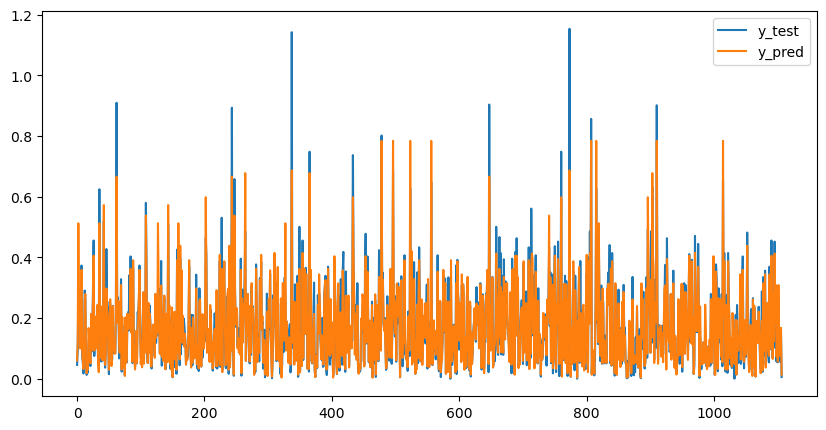

In [50]:
# 예측값과 실제값 비교
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()
plt.show()

In [65]:
# 모델 저장
joblib.dump(xgb_model, 'model/xgboost_test4.pkl')

['model/xgboost_test4.pkl']

In [66]:
# 모델 불러오기
model_2 = joblib.load('model/xgboost_test4.pkl')

# 모델 예측
test_pre2 = model_2.predict(test_X)
# test_pre2 = model_2.predict(test_X)

In [67]:
# 역정규화 
scaler_y.inverse_transform(test_pre2.reshape(-1,1))

array([[6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [5847.481 ],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],
       [6088.9873],


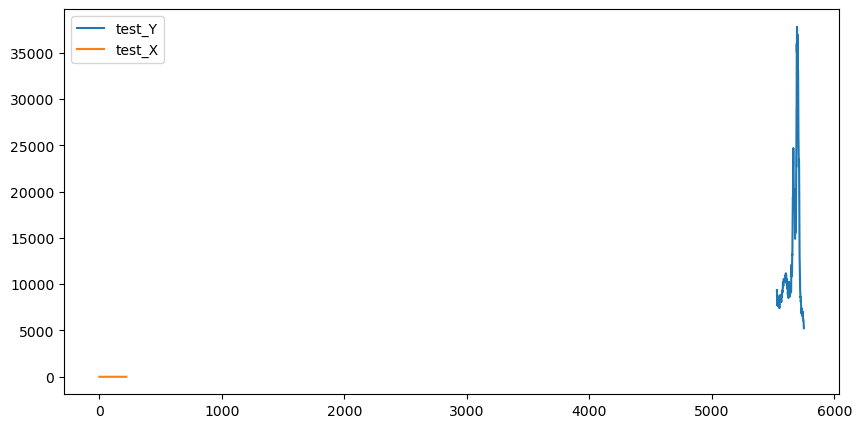

In [68]:
# 예측값과 실제값 비교
plt.figure(figsize=(10, 5))
plt.plot(test_Y, label='test_Y')
plt.plot(test_pre2, label='test_X')
plt.legend()
plt.show()

In [69]:
scale_test = scaler_x.transform(test_X)
pred_test = model_2.predict(scale_test)

In [70]:
pred_test = scaler_y.inverse_transform(pred_test.reshape(-1,1))

In [71]:
test_Y

5531    9362.0
5532    8640.0
5533    8720.0
5534    8114.0
5535    7994.0
         ...  
5747    6100.0
5748    6100.0
5749    5664.0
5750    5592.0
5751    5242.0
Name: 평균, Length: 221, dtype: float64

In [72]:
pred_test

array([[ 8239.133 ],
       [ 8239.133 ],
       [ 8239.133 ],
       [ 8239.133 ],
       [ 8239.133 ],
       [ 8239.133 ],
       [ 8239.133 ],
       [ 8239.133 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9081.298 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602.772 ],
       [ 9602

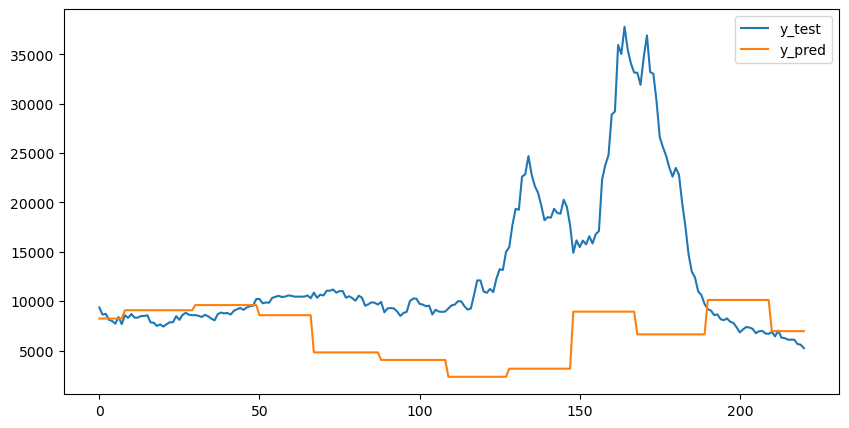

In [73]:
# 예측값과 실제값 비교
plt.figure(figsize=(10, 5))
plt.plot(test_Y.tolist(), label='y_test')
plt.plot(pred_test, label='y_pred')
plt.legend()
plt.show()

In [74]:
# 평가
print('MSE :', mean_squared_error(test_Y, pred_test))
print('R2 :', r2_score(test_Y, pred_test))

MSE : 101263839.4577843
R2 : -0.9181487572940492


In [120]:
pred_test

array([[1368.7196],
       [1368.7196],
       [1365.5652],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1360.1202],
       [1383.1652],
       [1395.7981],
       [1425.022 ],
       [1427.0243],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1429.4996],
       [1488.5149],
       [1542.0271],
       [1592.9629],
       [1595.6545],
       [1600.2166],
       [1600.2166],
       [1600.2166],
       [1600.2166],
       [1600.2166],
       [1600.2166],
       [1600.2166],
       [1600.2166],
